In [1]:
import sys
import os
sys.path.append('..')
sys.path.append('../failure_directions')
import torch
import torchvision
import failure_directions
import numpy as np
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


import failure_directions.src.svm_utils as svm_utils
import failure_directions.src.visualization_utils as viz_utils
import failure_directions.src.ds_utils as ds_utils
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from failure_directions.src.label_maps import CLASS_DICT
import pickle as pkl
from torchvision.datasets.folder import pil_loader


/mnt/cfs/home/saachij/conda_envs/ffcv_cfs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set()
BLUE = sns.color_palette("tab10")[0]
RED = sns.color_palette("tab10")[3]
ORANGE = sns.color_palette("tab10")[1]
BROWN = sns.color_palette("tab10")[5]
GRAY = sns.color_palette("tab10")[7]
GREEN = sns.color_palette("tab10")[2]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (5, 3),
         'axes.labelsize': 14,
         'axes.titlesize':16,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)


In [3]:
#Load SVM Model
beton_root = "/mnt/cfs/projects/correlated_errors/betons"
experiment_root = "/mnt/cfs/projects/correlated_errors/experiments/cifar/cifar_0.25"

svm_name = "svm_cifar_0.25_unlabeled_normalized"
name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}.pt") # SVM output file
svm_model_name = os.path.join(experiment_root, f"svm_checkpoints/{svm_name}_model.pkl") # SVM output file
model_root = os.path.join(experiment_root, "models")
model_ckpt = os.path.join(model_root, "cifar10_0.25_unlabeled/version_0/checkpoints/checkpoint_last.pt")
loss_upweight_root = os.path.join(experiment_root, "loss_vec_files")
subset_root = os.path.join(experiment_root, "subset_index_files")

%cd ../failure_directions
processor = viz_utils.SVMProcessor(name, root=beton_root, checkpoint_path=model_ckpt, get_unlabeled=True)
%cd ../analysis_nbs
svm_model = processor._build_model(model_ckpt)


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
-----------train_metrics--------------
{'Confusion Matrix': array([[ 439,  192],
       [3195, 6174]]),
 'Model Accuracy': 0.9369,
 'SVM Accuracy': 0.661300003528595,
 'SVM Balanced Accuracy': 0.6773514151573181}
-----------val_metrics--------------
{'Confusion Matrix': array([[1593,  415],
       [1713, 6279]]),
 'Model Accuracy': 0.7992,
 'SVM Accuracy': 0.7871999740600586,
 'SVM Balanced Accuracy': 0.7894936800003052}
-----------test_metrics--------------
{'Confusion Matrix': array([[1346,  749],
       [2007, 5898]]),
 'Model Accuracy': 0.7905,
 'SVM Accuracy': 0.724399983882904,
 'SVM Balanced Accuracy': 0.6942960917949677}
-----------unlabeled_metrics--------------
{'Confusion Matrix': array([[ 3972,  2185],
       [ 5945, 17898]]),
 'Model Accuracy': 0.7947666666666666,
 'SVM Accuracy': 0.7289999723434448,
 'SVM Balanced Accuracy': 0.6978899836540222}
Using default os_cache: False
Using default quasi_random: True
Us

100%|██████████| 100/100 [00:05<00:00, 19.31it/s]


Accuracy 0.9472000002861023


100%|██████████| 100/100 [00:01<00:00, 83.81it/s]


Accuracy 0.7991999983787537


100%|██████████| 100/100 [00:01<00:00, 59.33it/s]


Accuracy 0.7904999852180481


100%|██████████| 300/300 [00:01<00:00, 153.54it/s]


Accuracy 0.7947999835014343
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs
{'training_args': {'epochs': 35, 'lr': 0.5, 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005}, 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}, 'iters_per_epoch': 19}, 'epoch': 34, 'training_metrics': {'loss': 0.17487808826722598, 'acc': 0.9425370065789473}, 'val_metrics': {'loss': 0.6609623561382294, 'acc': 0.7992000002861023}}


In [4]:
split = 'test'
test_dv = processor.metrics[f'{split}_metrics']['decision_values']
test_confs = processor.run_dict[split]['confs']
test_class = processor.metrics[f'{split}_metrics']['classes'] # 0 if female, 1 if male
test_pred_correct = processor.metrics[f'{split}_metrics']['ypred']
test_correct = processor.metrics[f'{split}_metrics']['ytrue']

In [5]:
from failure_directions.src.config_parsing import ffcv_read_check_override_config
import yaml
%cd ../failure_directions
with open(processor.metrics['args']['config'], 'r') as file:
    fresh_hparams = yaml.safe_load(file)
fresh_hparams = ffcv_read_check_override_config(fresh_hparams)
%cd ../analysis_nbs


/mnt/cfs/home/saachij/src/failure-directions/failure_directions
Using default os_cache: False
Using default quasi_random: True
Using default val_aug: None
Using default loss_vec_file: None
Using default indices_file: None
Using default val_beton: None
Using default unlabeled_beton: None
Using default loss_upweight: 5
Using default bce: False
Using default cmnist: False
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs


## Get SVM Directions

In [6]:
# Get big CLIP features
hparams = processor.hparams

clip_processor = failure_directions.CLIPProcessor(ds_mean=hparams['mean'], ds_std=hparams['std'], arch='ViT-L/14')
clip_features = {}
for split, loader in processor.loaders.items():
    clip_features[split] = clip_processor.evaluate_clip_images(loader)

100%|██████████| 300/300 [01:38<00:00,  3.04it/s]


In [7]:
svm_fitter = failure_directions.SVMFitter()
# svm_fitter.set_preprocess()
svm_fitter.set_preprocess(clip_features['train'])
val_gts, val_preds = processor.run_dict['val']['ys'], processor.run_dict['val']['preds']
cv_scores = svm_fitter.fit(preds=val_preds, ys=val_gts, latents=clip_features['val'])

test_ys = processor.run_dict['test']['ys']
test_latents = clip_features['test']
big_clip_dv = svm_fitter.predict(ys=test_ys, latents=test_latents, compute_metrics=False)[1]

/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cf

updating whitening


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

In [10]:
svm_fitter.export("cifar_10_svm_large.pt")

In [13]:
svm_fitter_pre_stats = svm_fitter.pre_process._export()

---


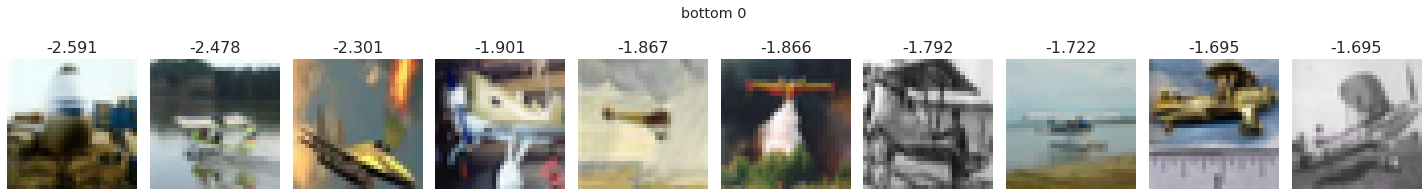

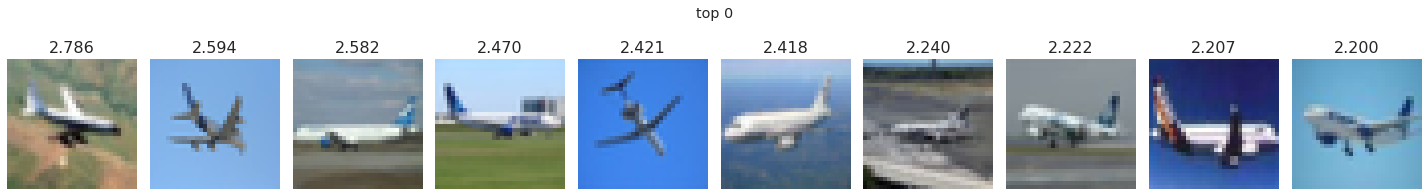



---


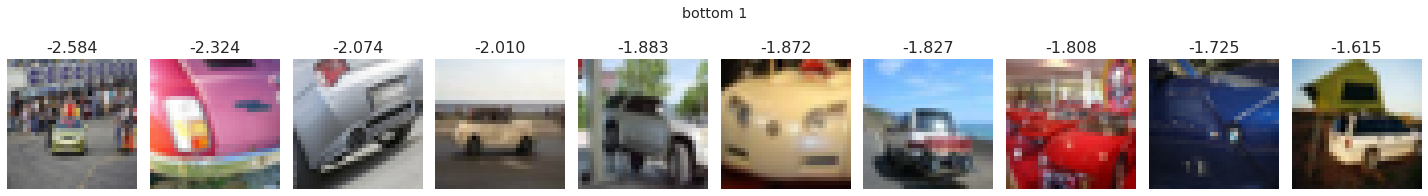

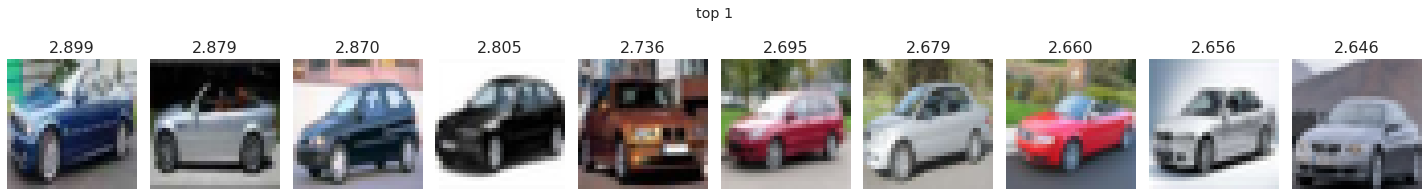



---


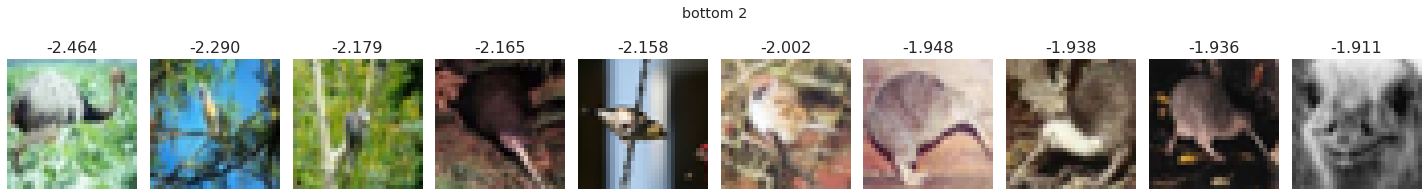

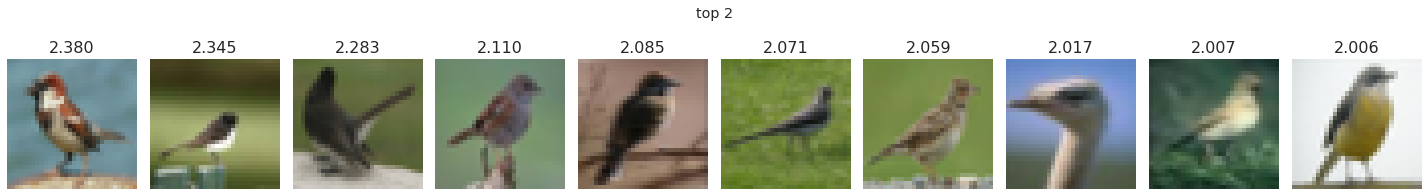



---


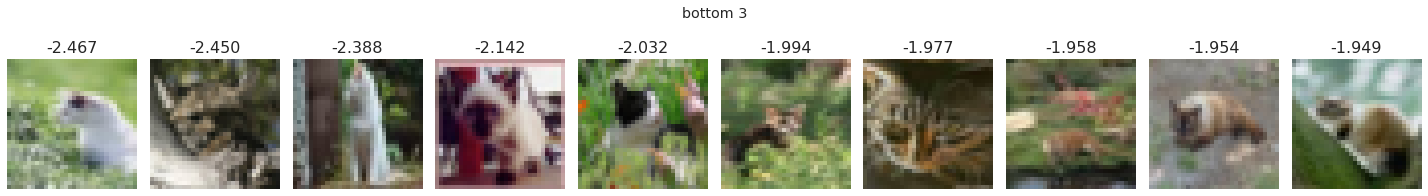

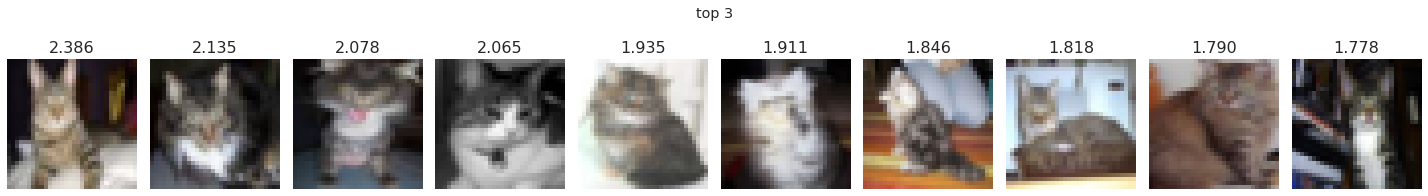



---


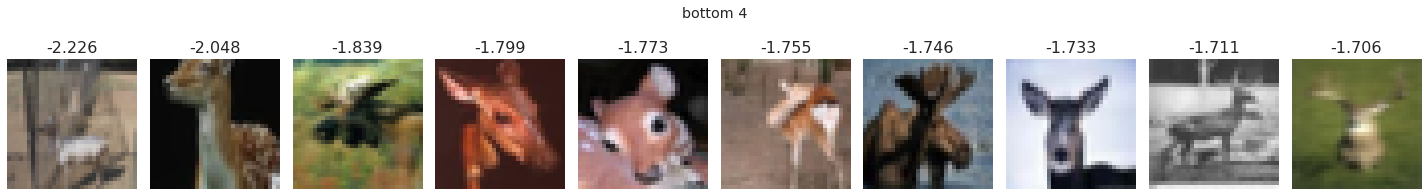

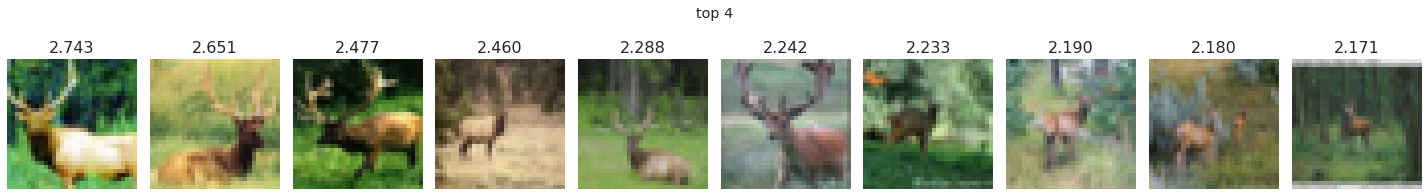



---


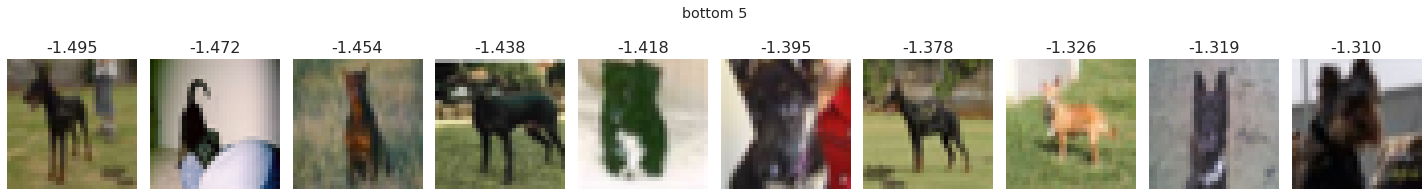

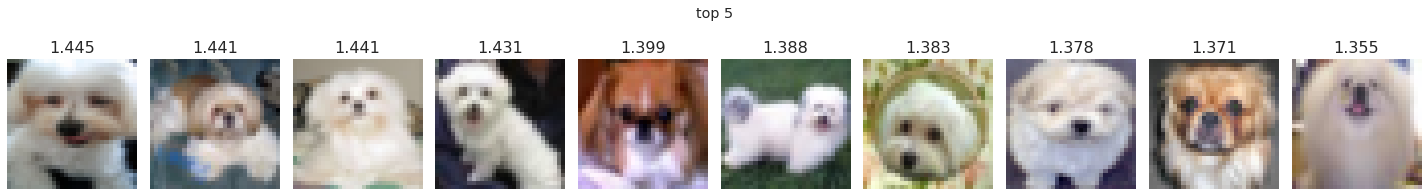



---


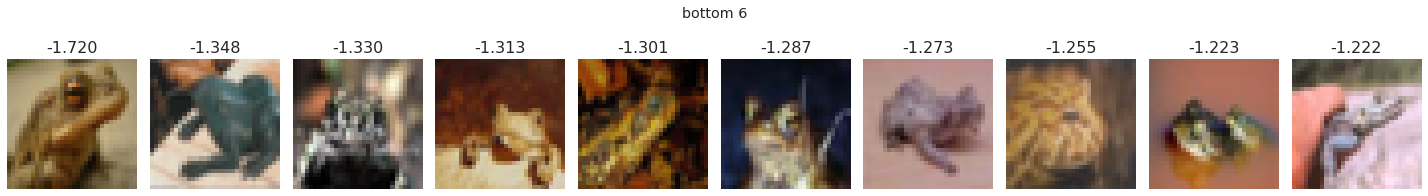

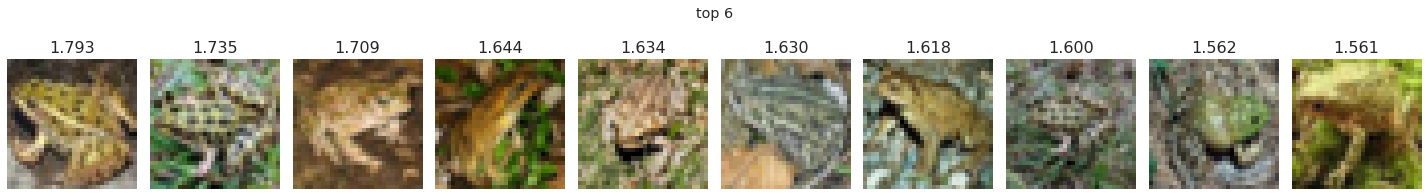



---


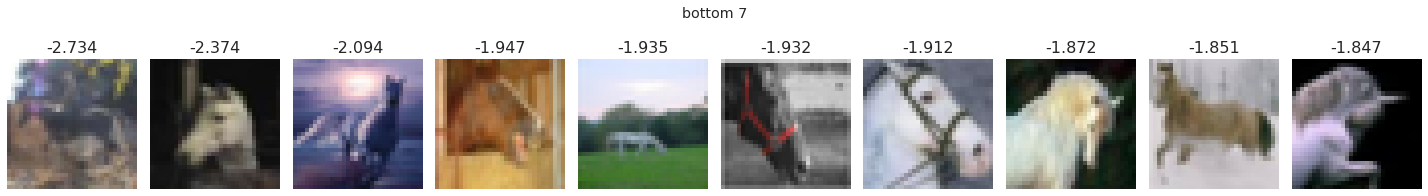

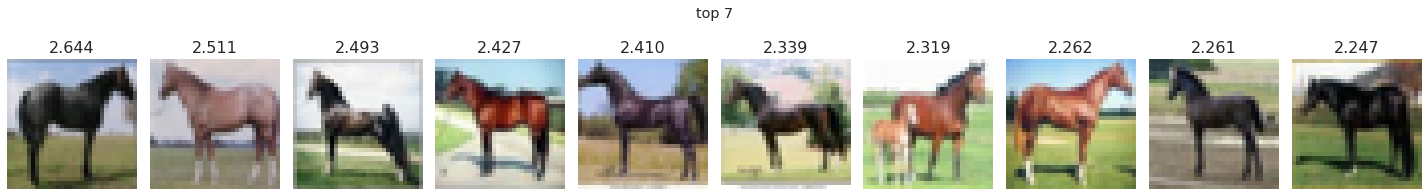



---


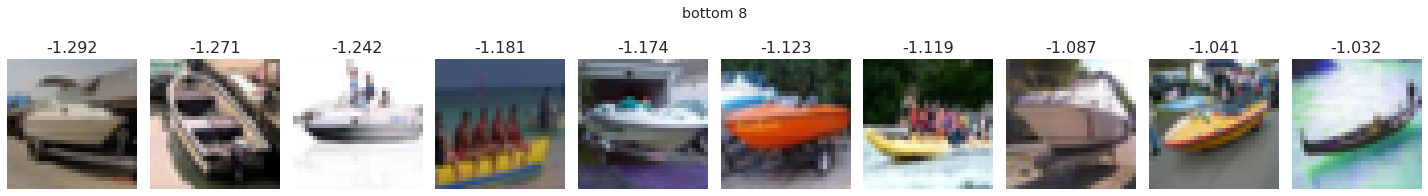

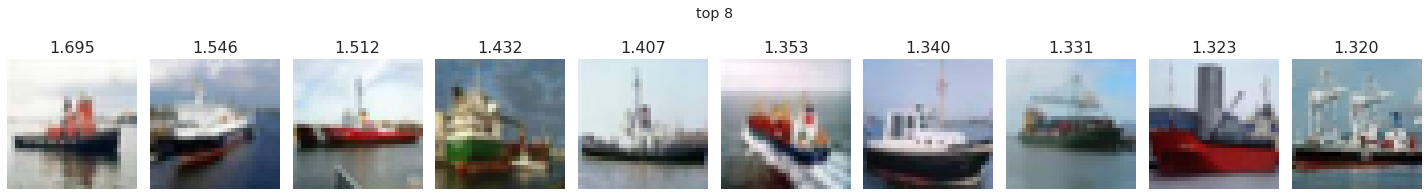



---


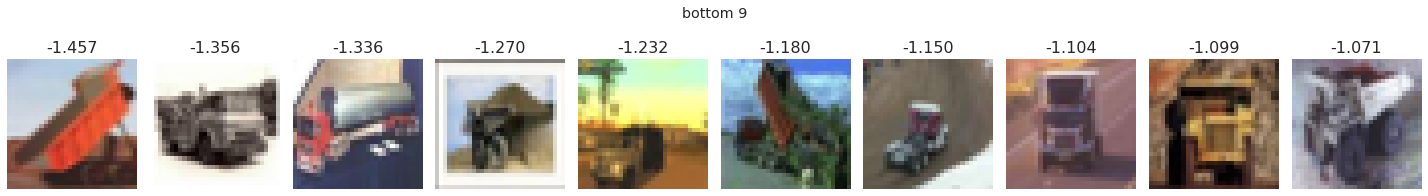

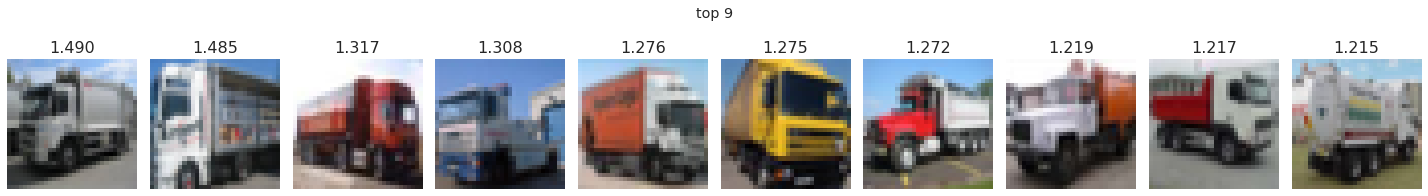

In [34]:
ds_root = "/mnt/cfs/datasets/cifar"
tds = torchvision.datasets.CIFAR10(ds_root, train=False)

def visualize_images(ds, ds_indices, ds_values, K=10, title=""):
    fig, ax = plt.subplots(1, K, figsize=(K*2, 3))
    for i in range(K):
        idx = ds_indices[i]
        ax[i].imshow(tds[idx][0])
        ax[i].axis(False)
        ax[i].set_title(f"{ds_values[i]:0.3f}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

gts = test_class
for c in range(10):
    print("---")
    mask = gts == c
    masked_indices = np.arange(len(mask))[mask]
    dv = big_clip_dv[mask]
    bottom_dv = np.argsort(dv)
    top_dv = bottom_dv[::-1]
    for order_name, order, cap in (
        ('bottom', bottom_dv, f"bottom {c}"),
        ("top", top_dv, f"top {c}"),
    ):
        vals = dv[order]
        visualize_images(tds, masked_indices[order], vals, title=cap)
        print("\n")
    

In [32]:
from failure_directions.src.clip_utils import get_caption_set

output_dir = "cifar_large_normalized_dir"
os.makedirs(output_dir, exist_ok=True)
mean, std = svm_fitter_pre_stats['mean'].numpy(), svm_fitter_pre_stats['std'].numpy()
for i in range(10):
    d = svm_fitter.clfs[i].coef_.squeeze(0)
    d = (d * std) + mean
    d = d/np.linalg.norm(d)
    np.save(f"{output_dir}/dir{i}.npy", d)
    
captions = failure_directions.get_caption_set('CIFAR')
ref_captions = clip_processor.evaluate_clip_captions(captions['reference'])
np.save(f"{output_dir}/ref_captions.npy", ref_captions.numpy())

no_photo_captions = [u.split("a photo of ")[1] for u in captions['reference']]
ref_captions = clip_processor.evaluate_clip_captions(no_photo_captions)
np.save(f"{output_dir}/no_photo_ref_captions.npy", ref_captions.numpy())

excluding bullterrier
excluding flat-coated retriever
excluding german short-haired pointer
excluding bedlington terrier
excluding entlebucher
excluding appenzeller
excluding seizure-alert dog
excluding brabancon griffon
excluding doberman
excluding liver-spotted dalmatian
excluding shetland sheepdog
excluding malamute
excluding weimaraner
excluding rottweiler
excluding dandie dinmont
excluding norwich terrier
excluding old english sheepdog
excluding coonhound
excluding blenheim spaniel
excluding vizsla
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding sennenhunde
excluding great pyrenees
excluding curly-coated retriever
excluding clumber
excluding pekinese
excluding coondog
excluding american staffordshire terrier
excluding black-and-tan coonhound
excluding black-and-tan coonhound
excluding smooth-haired fox terrier
excluding belgian sheepdog
excluding shih-tzu
excluding plott hound
excluding bluetick
excluding bouvier des flandres
excluding bouvier des

100%|██████████| 11/11 [00:00<00:00, 163.30it/s]


dog
bird
automobile
airplane
truck
ship
frog
cat
horse
deer
reference


100%|██████████| 1/1 [00:00<00:00, 100.34it/s]


In [10]:
import os
os.makedirs("cifar_large_directions")
for i in range(10):
    d = svm_fitter.clfs[i].coef_.squeeze(0)
    np.save(f"cifar_large_directions/dir{i}.npy", d/np.linalg.norm(d))

In [11]:
from failure_directions.src.clip_utils import get_caption_set
captions = failure_directions.get_caption_set('CIFAR')
ref_captions = clip_processor.evaluate_clip_captions(captions['reference'])
np.save("cifar_large_directions/ref_captions.npy", ref_captions.numpy())

excluding sennenhunde
excluding appenzeller
excluding smooth-haired fox terrier
excluding great pyrenees
excluding flat-coated retriever
excluding seizure-alert dog
excluding black-and-tan coonhound
excluding black-and-tan coonhound
excluding rhodesian ridgeback
excluding dandie dinmont
excluding rottweiler
excluding staffordshire bullterrier
excluding staffordshire bullterrier
excluding coonhound
excluding leonberg
excluding bluetick
excluding pekinese
excluding curly-coated retriever
excluding bullterrier
excluding clumber
excluding shetland sheepdog
excluding liver-spotted dalmatian
excluding lapdog
excluding shih-tzu
excluding weimaraner
excluding old english sheepdog
excluding blenheim spaniel
excluding coondog
excluding brabancon griffon
excluding bedlington terrier
excluding doberman
excluding bouvier des flandres
excluding bouvier des flandres
excluding bouvier des flandres
excluding entlebucher
excluding malamute
excluding norwich terrier
excluding housedog
excluding vizsla
ex

  0%|          | 0/11 [00:00<?, ?it/s]

dog
bird


100%|██████████| 11/11 [00:00<00:00, 159.66it/s]


automobile
airplane
truck
ship
frog
cat
horse
deer
reference


100%|██████████| 1/1 [00:00<00:00, 102.43it/s]


## Read the generated images

In [6]:
import src.stable_diffusion_utils as sd_utils
from src.stable_diffusion_utils import DiffDataset

In [7]:
images_path = "/mnt/cfs/home/saachij/src/stable-diffusion/slerp_images_9_19"

In [8]:
path_dict = sd_utils.get_path_dict(images_path, num_classes=10)
print(len(path_dict[0]['flip'][0]))

90


In [39]:
import torchvision.transforms as transforms
import torchvision
from failure_directions.src.decoders_and_transforms import PyTranslate, PyCutOut
hparams = processor.hparams

fill_color = tuple(map(int, hparams['mean']))

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=np.array(hparams['mean'])/255, std=np.array(hparams['std'])/255)])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    PyTranslate(2),
    PyCutOut(4, fill_color),
    base_transform
])

# For visualization
INV_NORM = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [255/x for x in hparams['std']]),
                                transforms.Normalize(mean = [-x /255 for x in hparams['mean']],
                                                     std = [ 1., 1., 1. ])])
TOIMAGE = transforms.Compose([INV_NORM, transforms.ToPILImage()])
resize_base_transform = transforms.Compose([base_transform, transforms.Resize((32, 32))])
resize_train_transform = transforms.Compose([train_transform, transforms.Resize((32, 32))])

In [40]:
def evaluate_model(model, loader):
    with torch.no_grad():
        with autocast():
            gts, preds, confs = [], [], []
            for x, y in tqdm(loader):
                x = x.cuda()
                logits = model(x)
                gts.append(y.cpu())
                preds.append(logits.argmax(-1).cpu())
                softmax_logits = nn.Softmax(dim=-1)(logits)
                confs.append(softmax_logits[torch.arange(logits.shape[0]), y].cpu())
    gts = torch.cat(gts)
    preds = torch.cat(preds)
    confs = torch.cat(confs)
    return gts, preds, confs

100%|██████████| 3/3 [00:00<00:00, 24.84it/s]


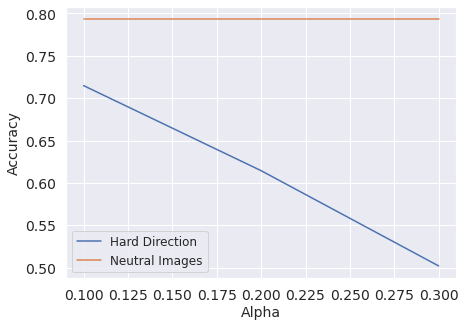

100%|██████████| 3/3 [00:00<00:00, 23.63it/s]


0 0.8999999761581421 0.8999999761581421 0.823


100%|██████████| 3/3 [00:00<00:00, 23.97it/s]


1 0.7777777910232544 1.0 0.905


100%|██████████| 3/3 [00:00<00:00, 24.02it/s]


2 0.25 0.625 0.695


100%|██████████| 3/3 [00:00<00:00, 23.44it/s]


3 0.5833333134651184 0.7916666865348816 0.616


100%|██████████| 3/3 [00:00<00:00, 23.42it/s]


4 0.6666666865348816 0.875 0.751


100%|██████████| 3/3 [00:00<00:00, 23.97it/s]


5 0.375 0.5416666865348816 0.663


100%|██████████| 3/3 [00:00<00:00, 23.48it/s]


6 0.2916666567325592 0.625 0.851


100%|██████████| 3/3 [00:00<00:00, 23.37it/s]


7 0.8333333134651184 0.9166666865348816 0.834


100%|██████████| 3/3 [00:00<00:00, 23.50it/s]


8 0.5833333134651184 0.875 0.903


100%|██████████| 3/3 [00:00<00:00, 24.17it/s]

9 0.7916666865348816 0.7083333134651184 0.864


In [42]:
# See relative accuracies
def get_diff_predictions(flip_name, intensity,target_class=None):
    base_ds = DiffDataset(path_dict, flip_name=flip_name, intensity=intensity, transform=resize_base_transform)
    base_loader = torch.utils.data.DataLoader(base_ds, batch_size=100, shuffle=False, drop_last=False)
    gts, preds, confs = evaluate_model(svm_model, base_loader)
    if target_class is not None:
        mask = gts == target_class
        gts, preds, confs = gts[mask], preds[mask], confs[mask]
    return gts, preds, confs, (gts==preds).float().mean().item()

intensities = [0.1, 0.2, 0.3]
base_acc = get_diff_predictions(flip_name="flip", intensity=0)[3]
flip_accs = [get_diff_predictions(flip_name="flip", intensity=u)[3] for u in intensities]
# no_flip_accs = [get_diff_predictions(flip_name="no_flip", intensity=u)[3] for u in intensities]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.lineplot(x=intensities, y=flip_accs, label='Hard Direction', ax=ax)
# sns.lineplot(x=intensities, y=no_flip_accs, label='Easy Direction', ax=ax)
sns.lineplot(x=intensities, y=[base_acc]*len(intensities), label='Neutral Images', ax=ax)
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
plt.show()

base_accs = []
flip_accs = []
orig_accs = []
for c in range(10):
    base_acc = get_diff_predictions(flip_name="flip", intensity=0, target_class=c)[3]
    flip_acc = get_diff_predictions(flip_name="flip", intensity=0.2, target_class=c)[3]
    orig_acc = (test_correct[test_class == c]).mean()
    print(c, flip_acc, base_acc, orig_acc)
    base_accs.append(base_acc)
    orig_accs.append(orig_acc)
    flip_accs.append(flip_acc)


In [14]:
for c in range(10):
    print(len(path_dict[c]['flip'][0]))

120
108
108
108
108
108
105
105
105
105


In [28]:
print(*zip(np.arange(10), cifar_label_list))

(0, 'airplane') (1, 'automobile') (2, 'bird') (3, 'cat') (4, 'deer') (5, 'dog') (6, 'frog') (7, 'horse') (8, 'ship') (9, 'truck')


# Train models

In [14]:
bsz = fresh_hparams['batch_size']
ds_root = "/mnt/cfs/datasets/cifar"
orig_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=base_transform)
aug_train_ds = torchvision.datasets.CIFAR10(ds_root, train=True, transform=train_transform)
test_ds = torchvision.datasets.CIFAR10(ds_root, train=False, transform=base_transform)

val_indices = processor.indices_dict['val_indices']
train_indices = processor.indices_dict['train_indices']

train_ds = torch.utils.data.Subset(aug_train_ds, train_indices)
val_ds = torch.utils.data.Subset(orig_train_ds, val_indices)
no_aug_train_ds = torch.utils.data.Subset(orig_train_ds, train_indices)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True, drop_last=True)
no_shuffle_train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=False, drop_last=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bsz, shuffle=False, drop_last=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bsz, shuffle=False, drop_last=False)
no_aug_train_loader = torch.utils.data.DataLoader(no_aug_train_ds, batch_size=bsz, shuffle=False, drop_last=False)



In [125]:
import copy

def run_model(train_loader_, val_loader_, test_loader_, set_device=False):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = build_fn(hparams['arch'], hparams['num_classes'])
    model = model.cuda()

    training_args=hparams['training']
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

def run_finetune_model(train_loader_, val_loader_, test_loader_, set_device=False, freeze=True):
    build_fn = failure_directions.model_utils.BUILD_FUNCTIONS[hparams['arch_type']]
    model = copy.deepcopy(svm_model).train()
    
    if freeze:
        for name, p in model.named_parameters():
            if name.split('.')[0] != 'linear':
                print("freezing", name)
                p.requires_grad = False


    training_args=finetune_training
    training_args['iters_per_epoch'] = len(train_loader_)
    trainer = failure_directions.LightWeightTrainer(training_args=training_args,
                                                    exp_name='temp', enable_logging=False,
                                                    bce=False, set_device=set_device)
    trainer.fit(model, train_loader_, val_loader_)
    return evaluate_model(model, test_loader_)

In [121]:
len(path_dict[0]['flip'][0.3])

138

In [124]:
finetune_training = {
 'epochs': 15,
 'lr': 0.1,
 'optimizer': {'momentum': 0.9, 'weight_decay': 0.0005},
 'lr_scheduler': {'type': 'cyclic', 'lr_peak_epoch': 5}
}

In [126]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform)
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True, freeze=False)
    

Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.483, acc=0.86] 


LR: 0.020000000000000004, Train Loss: 0.2450, Train Acc: 0.9185, Val Loss: 0.7114, Val Acc: 0.7875


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.68it/s, loss=0.384, acc=0.879]


LR: 0.04000000000000001, Train Loss: 0.2072, Train Acc: 0.9299, Val Loss: 0.7046, Val Acc: 0.7898


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.605, acc=0.835]


LR: 0.06000000000000001, Train Loss: 0.2064, Train Acc: 0.9295, Val Loss: 0.7676, Val Acc: 0.7743


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.244, acc=0.908]


LR: 0.08000000000000002, Train Loss: 0.2183, Train Acc: 0.9243, Val Loss: 0.8889, Val Acc: 0.7502


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.622, acc=0.857]


LR: 0.1, Train Loss: 0.2593, Train Acc: 0.9078, Val Loss: 1.0397, Val Acc: 0.7010


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.61, acc=0.827] 


LR: 0.09000000000000001, Train Loss: 0.2827, Train Acc: 0.8993, Val Loss: 0.8340, Val Acc: 0.7590


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.68it/s, loss=0.781, acc=0.768]


LR: 0.08000000000000002, Train Loss: 0.2346, Train Acc: 0.9167, Val Loss: 0.7949, Val Acc: 0.7645


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.737, acc=0.779]


LR: 0.06999999999999999, Train Loss: 0.2002, Train Acc: 0.9317, Val Loss: 0.7589, Val Acc: 0.7832


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.365, acc=0.886]


LR: 0.06, Train Loss: 0.1575, Train Acc: 0.9469, Val Loss: 0.7794, Val Acc: 0.7810


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=0.582, acc=0.857]


LR: 0.05, Train Loss: 0.1278, Train Acc: 0.9577, Val Loss: 0.7571, Val Acc: 0.7868


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.537, acc=0.857]


LR: 0.039999999999999994, Train Loss: 0.1129, Train Acc: 0.9621, Val Loss: 0.7794, Val Acc: 0.7928


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.554, acc=0.849]


LR: 0.029999999999999995, Train Loss: 0.0859, Train Acc: 0.9740, Val Loss: 0.7690, Val Acc: 0.7928


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.418, acc=0.871]


LR: 0.019999999999999997, Train Loss: 0.0674, Train Acc: 0.9816, Val Loss: 0.7134, Val Acc: 0.8052


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.519, acc=0.842]


LR: 0.009999999999999988, Train Loss: 0.0561, Train Acc: 0.9853, Val Loss: 0.7286, Val Acc: 0.8039


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.424, acc=0.879]


LR: 0.0, Train Loss: 0.0468, Train Acc: 0.9887, Val Loss: 0.7275, Val Acc: 0.8064


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.495, acc=0.838]


LR: 0.020000000000000004, Train Loss: 0.3542, Train Acc: 0.8920, Val Loss: 0.7618, Val Acc: 0.7743


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.315, acc=0.904]


LR: 0.04000000000000001, Train Loss: 0.2596, Train Acc: 0.9092, Val Loss: 0.7205, Val Acc: 0.7816


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.449, acc=0.882]


LR: 0.06000000000000001, Train Loss: 0.2284, Train Acc: 0.9215, Val Loss: 0.7412, Val Acc: 0.7795


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.54, acc=0.871] 


LR: 0.08000000000000002, Train Loss: 0.2153, Train Acc: 0.9239, Val Loss: 0.9234, Val Acc: 0.7499


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.801, acc=0.798]


LR: 0.1, Train Loss: 0.2684, Train Acc: 0.9033, Val Loss: 0.9788, Val Acc: 0.7302


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.47, acc=0.86]  


LR: 0.09000000000000001, Train Loss: 0.2755, Train Acc: 0.9001, Val Loss: 0.9071, Val Acc: 0.7474


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.641, acc=0.824]


LR: 0.08000000000000002, Train Loss: 0.2747, Train Acc: 0.9033, Val Loss: 0.8237, Val Acc: 0.7574


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.63it/s, loss=0.409, acc=0.882]


LR: 0.06999999999999999, Train Loss: 0.2172, Train Acc: 0.9236, Val Loss: 0.8204, Val Acc: 0.7702


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.479, acc=0.864]


LR: 0.06, Train Loss: 0.1710, Train Acc: 0.9428, Val Loss: 0.7554, Val Acc: 0.7846


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.64it/s, loss=0.6, acc=0.835]  


LR: 0.05, Train Loss: 0.1387, Train Acc: 0.9532, Val Loss: 0.7214, Val Acc: 0.7966


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.496, acc=0.846]


LR: 0.039999999999999994, Train Loss: 0.1102, Train Acc: 0.9634, Val Loss: 0.7369, Val Acc: 0.7865


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.60it/s, loss=0.406, acc=0.886]


LR: 0.029999999999999995, Train Loss: 0.0893, Train Acc: 0.9727, Val Loss: 0.7515, Val Acc: 0.7970


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.344, acc=0.882]


LR: 0.019999999999999997, Train Loss: 0.0728, Train Acc: 0.9792, Val Loss: 0.7199, Val Acc: 0.8058


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.52it/s, loss=0.329, acc=0.893]


LR: 0.009999999999999988, Train Loss: 0.0550, Train Acc: 0.9852, Val Loss: 0.6950, Val Acc: 0.8136


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=0.316, acc=0.904]


LR: 0.0, Train Loss: 0.0501, Train Acc: 0.9867, Val Loss: 0.6995, Val Acc: 0.8132


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.716, acc=0.805]


LR: 0.020000000000000004, Train Loss: 0.4134, Train Acc: 0.8793, Val Loss: 0.8029, Val Acc: 0.7600


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.402, acc=0.857]


LR: 0.04000000000000001, Train Loss: 0.2793, Train Acc: 0.9018, Val Loss: 0.7402, Val Acc: 0.7726


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.353, acc=0.901]


LR: 0.06000000000000001, Train Loss: 0.2367, Train Acc: 0.9195, Val Loss: 0.7695, Val Acc: 0.7732


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.56it/s, loss=0.468, acc=0.879]


LR: 0.08000000000000002, Train Loss: 0.2393, Train Acc: 0.9147, Val Loss: 0.8216, Val Acc: 0.7566


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.339, acc=0.901]


LR: 0.1, Train Loss: 0.2755, Train Acc: 0.9014, Val Loss: 0.8635, Val Acc: 0.7548


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.923, acc=0.746]


LR: 0.09000000000000001, Train Loss: 0.2959, Train Acc: 0.8952, Val Loss: 0.8501, Val Acc: 0.7508


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.769, acc=0.746]


LR: 0.08000000000000002, Train Loss: 0.2596, Train Acc: 0.9080, Val Loss: 0.8553, Val Acc: 0.7474


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=0.365, acc=0.912]


LR: 0.06999999999999999, Train Loss: 0.2320, Train Acc: 0.9171, Val Loss: 0.7922, Val Acc: 0.7729


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.50it/s, loss=0.361, acc=0.923]


LR: 0.06, Train Loss: 0.1847, Train Acc: 0.9361, Val Loss: 0.7789, Val Acc: 0.7751


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=0.79, acc=0.79]  


LR: 0.05, Train Loss: 0.1323, Train Acc: 0.9564, Val Loss: 0.7759, Val Acc: 0.7834


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s, loss=0.309, acc=0.919]


LR: 0.039999999999999994, Train Loss: 0.1105, Train Acc: 0.9637, Val Loss: 0.7264, Val Acc: 0.8002


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.515, acc=0.853]


LR: 0.029999999999999995, Train Loss: 0.0926, Train Acc: 0.9714, Val Loss: 0.7217, Val Acc: 0.7971


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.373, acc=0.912]


LR: 0.019999999999999997, Train Loss: 0.0700, Train Acc: 0.9810, Val Loss: 0.7086, Val Acc: 0.8054


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=0.455, acc=0.893]


LR: 0.009999999999999988, Train Loss: 0.0569, Train Acc: 0.9854, Val Loss: 0.7155, Val Acc: 0.8060


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.48it/s, loss=0.421, acc=0.89] 


LR: 0.0, Train Loss: 0.0522, Train Acc: 0.9879, Val Loss: 0.7049, Val Acc: 0.8083


100%|██████████| 20/20 [00:01<00:00, 11.08it/s]


tensor(0.7991) tensor(0.7991)
tensor(0.8008) tensor(0.7991)


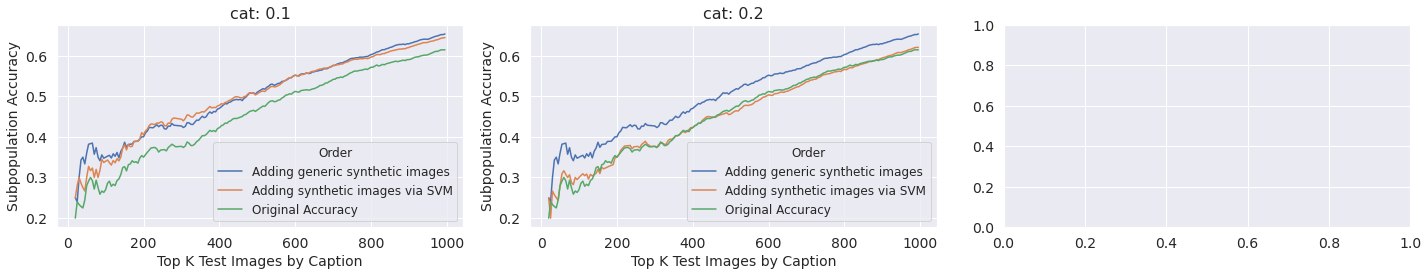

In [193]:
def get_dv_indices(target_c):
    dv = big_clip_dv
    mask = test_class == target_c
    inds = np.arange(len(dv))[mask]
    return inds[np.argsort(dv[mask])]

fig, ax_ = plt.subplots(1, 3, figsize=(20, 4))
cls = 3
for intensity_idx, intensity in enumerate([0.1, 0.2]):
    ax = ax_[intensity_idx]
    load_corrects = {
        'flip': [(flip_interventions[intensity][0] == flip_interventions[intensity][1])],
        'base': [(flip_interventions[0][0] == flip_interventions[0][1])],
        'baseline': [torch.tensor(test_correct == 1)],

    }
    trials = 1
    print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

    K = 100


    all_dfs = []
    # valid_classes = np.arange(10)
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 1000, 5)
        accs = {k:[] for k in load_corrects.keys()}
        for K in xaxis:
            minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
#             minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')][0][:K] for target_c in valid_classes])
            for k in load_corrects.keys():
                accs[k].append(load_corrects[k][v][minority_indices].float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = accs['base']
        df['Adding synthetic images via SVM'] = accs['flip']
        df['Original Accuracy'] = accs['baseline']
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    ax.set_title(f'{t}: {intensity}')
plt.tight_layout()
plt.show()


In [160]:
(test_class == 3).sum()

1000

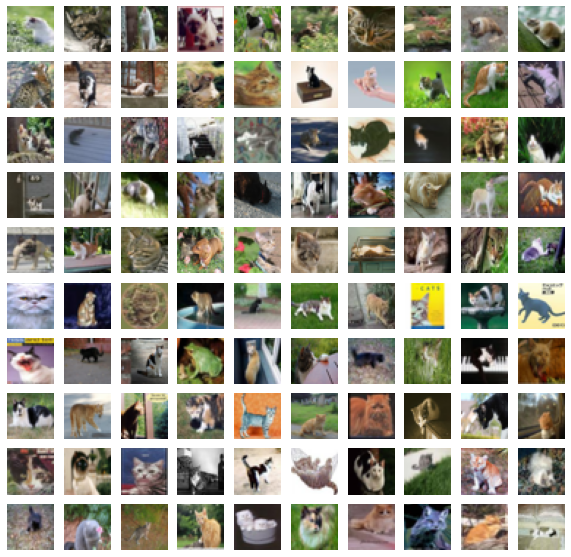

In [194]:
tds = torchvision.datasets.CIFAR10(ds_root, train=False)

fig, ax = plt.subplots(10, 10, figsize=(10, 10))
ax_ = ax.flatten()
for i in range(len(ax_)):
    ax_[i].imshow(tds[minority_indices[i]][0])
    ax_[i].grid(False)
    ax_[i].axis(False)
plt.show()

In [11]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2, 0.3]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform)
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = [
        run_finetune_model(synth_train_loader, val_loader, test_loader, set_device=True)
        for _ in range (1)
    ]

In [23]:
# See relative accuracies
flip_interventions = {}
for intensity in [0, 0.1, 0.2, 0.3]:
    base_synth_dataset = DiffDataset(path_dict, flip_name='flip', intensity=intensity, num_imgs_per_class=100,
                                     transform=resize_train_transform)
    synth_train_set = torch.utils.data.ConcatDataset([train_ds, base_synth_dataset])
    synth_train_loader = torch.utils.data.DataLoader(synth_train_set, batch_size=bsz, shuffle=True, drop_last=True)
    flip_interventions[intensity] = [
        run_model(synth_train_loader, val_loader, test_loader, set_device=True)
        for _ in range (1)
    ]

Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.71it/s, loss=410, acc=0]      


LR: 0.1, Train Loss: 2.5268, Train Acc: 0.1833, Val Loss: 356.9586, Val Acc: 0.1002


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.71it/s, loss=0.11, acc=0.993]  


LR: 0.2, Train Loss: 2.0611, Train Acc: 0.2586, Val Loss: 15.2539, Val Acc: 0.1237


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=1.85, acc=0.0625]


LR: 0.30000000000000004, Train Loss: 1.7978, Train Acc: 0.3296, Val Loss: 2.0766, Val Acc: 0.2964


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.61it/s, loss=2.59, acc=0.327] 


LR: 0.4, Train Loss: 1.6455, Train Acc: 0.3822, Val Loss: 1.9762, Val Acc: 0.3223


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.57it/s, loss=1.15, acc=0.574] 


LR: 0.5, Train Loss: 1.5891, Train Acc: 0.4106, Val Loss: 1.5233, Val Acc: 0.4346


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.77it/s, loss=1, acc=0.699]   


LR: 0.48333333333333334, Train Loss: 1.4867, Train Acc: 0.4503, Val Loss: 1.4605, Val Acc: 0.4520


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s, loss=0.948, acc=0.673]


LR: 0.4666666666666667, Train Loss: 1.3831, Train Acc: 0.4891, Val Loss: 1.4858, Val Acc: 0.4548


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.86it/s, loss=1.19, acc=0.643] 


LR: 0.45, Train Loss: 1.2655, Train Acc: 0.5397, Val Loss: 1.5856, Val Acc: 0.4429


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.93it/s, loss=0.771, acc=0.695]


LR: 0.43333333333333335, Train Loss: 1.1910, Train Acc: 0.5722, Val Loss: 1.2158, Val Acc: 0.5600


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.78it/s, loss=0.859, acc=0.739]


LR: 0.4166666666666667, Train Loss: 1.1091, Train Acc: 0.6028, Val Loss: 1.2512, Val Acc: 0.5426


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.71it/s, loss=0.406, acc=0.871]


LR: 0.4, Train Loss: 1.0427, Train Acc: 0.6266, Val Loss: 1.2463, Val Acc: 0.5645


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.77it/s, loss=2.92, acc=0.287] 


LR: 0.3833333333333333, Train Loss: 0.9823, Train Acc: 0.6457, Val Loss: 1.2838, Val Acc: 0.5713


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.80it/s, loss=1.04, acc=0.688] 


LR: 0.3666666666666667, Train Loss: 0.9140, Train Acc: 0.6721, Val Loss: 1.0638, Val Acc: 0.6240


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s, loss=1.24, acc=0.618] 


LR: 0.35, Train Loss: 0.8497, Train Acc: 0.6995, Val Loss: 1.1382, Val Acc: 0.5973


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.84it/s, loss=0.998, acc=0.68] 


LR: 0.33333333333333337, Train Loss: 0.7789, Train Acc: 0.7227, Val Loss: 1.0108, Val Acc: 0.6408


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 10.77it/s, loss=0.661, acc=0.779]


LR: 0.31666666666666665, Train Loss: 0.7601, Train Acc: 0.7333, Val Loss: 0.9438, Val Acc: 0.6687


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s, loss=1.92, acc=0.353] 


LR: 0.3, Train Loss: 0.7107, Train Acc: 0.7454, Val Loss: 1.2659, Val Acc: 0.5789


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 10.85it/s, loss=0.425, acc=0.864]


LR: 0.2833333333333333, Train Loss: 0.6484, Train Acc: 0.7695, Val Loss: 0.9536, Val Acc: 0.6795


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s, loss=0.71, acc=0.798] 


LR: 0.26666666666666666, Train Loss: 0.5772, Train Acc: 0.7954, Val Loss: 0.9451, Val Acc: 0.6842


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=1.16, acc=0.629] 


LR: 0.25, Train Loss: 0.5529, Train Acc: 0.8016, Val Loss: 0.9037, Val Acc: 0.6919


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s, loss=0.362, acc=0.89] 


LR: 0.23333333333333334, Train Loss: 0.5239, Train Acc: 0.8162, Val Loss: 0.8039, Val Acc: 0.7283


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 10.88it/s, loss=0.461, acc=0.879]


LR: 0.21666666666666667, Train Loss: 0.4855, Train Acc: 0.8268, Val Loss: 0.7736, Val Acc: 0.7378


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 10.83it/s, loss=1.18, acc=0.636] 


LR: 0.2, Train Loss: 0.4318, Train Acc: 0.8450, Val Loss: 1.0266, Val Acc: 0.6740


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 10.68it/s, loss=1.31, acc=0.581] 


LR: 0.18333333333333335, Train Loss: 0.4123, Train Acc: 0.8519, Val Loss: 0.8514, Val Acc: 0.7187


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 10.90it/s, loss=0.484, acc=0.849]


LR: 0.16666666666666669, Train Loss: 0.3716, Train Acc: 0.8674, Val Loss: 0.7858, Val Acc: 0.7451


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 10.88it/s, loss=0.97, acc=0.717] 


LR: 0.15000000000000002, Train Loss: 0.3406, Train Acc: 0.8795, Val Loss: 0.8046, Val Acc: 0.7426


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 10.84it/s, loss=0.668, acc=0.805]


LR: 0.13333333333333336, Train Loss: 0.3078, Train Acc: 0.8922, Val Loss: 0.7166, Val Acc: 0.7698


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 10.78it/s, loss=0.788, acc=0.772]


LR: 0.11666666666666664, Train Loss: 0.2682, Train Acc: 0.9054, Val Loss: 0.7101, Val Acc: 0.7754


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s, loss=0.244, acc=0.926]


LR: 0.09999999999999998, Train Loss: 0.2278, Train Acc: 0.9228, Val Loss: 0.6925, Val Acc: 0.7835


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 10.68it/s, loss=0.382, acc=0.893]


LR: 0.08333333333333331, Train Loss: 0.1844, Train Acc: 0.9366, Val Loss: 0.6871, Val Acc: 0.7936


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 10.79it/s, loss=0.5, acc=0.849]  


LR: 0.06666666666666665, Train Loss: 0.1666, Train Acc: 0.9447, Val Loss: 0.6808, Val Acc: 0.7980


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 10.88it/s, loss=0.291, acc=0.926]


LR: 0.04999999999999999, Train Loss: 0.1330, Train Acc: 0.9578, Val Loss: 0.6812, Val Acc: 0.8022


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 10.83it/s, loss=0.29, acc=0.93]  


LR: 0.033333333333333326, Train Loss: 0.1103, Train Acc: 0.9635, Val Loss: 0.6673, Val Acc: 0.8095


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.355, acc=0.904]


LR: 0.016666666666666663, Train Loss: 0.0930, Train Acc: 0.9703, Val Loss: 0.6414, Val Acc: 0.8154


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 10.81it/s, loss=0.334, acc=0.908]


LR: 0.0, Train Loss: 0.0755, Train Acc: 0.9783, Val Loss: 0.6324, Val Acc: 0.8200


Val Epoch: 0: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0, acc=1]          


LR: 0.1, Train Loss: 2.5475, Train Acc: 0.1810, Val Loss: 3332.1620, Val Acc: 0.1000


Val Epoch: 1: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s, loss=23, acc=0]        


LR: 0.2, Train Loss: 2.4198, Train Acc: 0.2000, Val Loss: 28.0189, Val Acc: 0.1380


Val Epoch: 2: 100%|██████████| 20/20 [00:01<00:00, 10.86it/s, loss=2.07, acc=0.408] 


LR: 0.30000000000000004, Train Loss: 1.9321, Train Acc: 0.2890, Val Loss: 1.9793, Val Acc: 0.3150


Val Epoch: 3: 100%|██████████| 20/20 [00:01<00:00, 10.84it/s, loss=2.27, acc=0.165]


LR: 0.4, Train Loss: 1.7734, Train Acc: 0.3432, Val Loss: 1.7935, Val Acc: 0.3740


Val Epoch: 4: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=1.78, acc=0.327] 


LR: 0.5, Train Loss: 1.6718, Train Acc: 0.3828, Val Loss: 1.6304, Val Acc: 0.3777


Val Epoch: 5: 100%|██████████| 20/20 [00:01<00:00, 10.79it/s, loss=1.4, acc=0.364]  


LR: 0.48333333333333334, Train Loss: 1.6089, Train Acc: 0.4089, Val Loss: 1.6518, Val Acc: 0.4113


Val Epoch: 6: 100%|██████████| 20/20 [00:01<00:00, 10.87it/s, loss=0.572, acc=0.915]


LR: 0.4666666666666667, Train Loss: 1.5077, Train Acc: 0.4419, Val Loss: 1.7352, Val Acc: 0.3526


Val Epoch: 7: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=1.61, acc=0.574] 


LR: 0.45, Train Loss: 1.4115, Train Acc: 0.4846, Val Loss: 1.5658, Val Acc: 0.4371


Val Epoch: 8: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=1.97, acc=0.371] 


LR: 0.43333333333333335, Train Loss: 1.2999, Train Acc: 0.5286, Val Loss: 1.6449, Val Acc: 0.4242


Val Epoch: 9: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=1.74, acc=0.36]  


LR: 0.4166666666666667, Train Loss: 1.2414, Train Acc: 0.5557, Val Loss: 1.5043, Val Acc: 0.4590


Val Epoch: 10: 100%|██████████| 20/20 [00:01<00:00, 10.44it/s, loss=1.39, acc=0.482] 


LR: 0.4, Train Loss: 1.1278, Train Acc: 0.5974, Val Loss: 1.2720, Val Acc: 0.5322


Val Epoch: 11: 100%|██████████| 20/20 [00:01<00:00, 10.79it/s, loss=1.45, acc=0.408]


LR: 0.3833333333333333, Train Loss: 1.0454, Train Acc: 0.6309, Val Loss: 1.2861, Val Acc: 0.5389


Val Epoch: 12: 100%|██████████| 20/20 [00:01<00:00, 10.73it/s, loss=1.43, acc=0.618] 


LR: 0.3666666666666667, Train Loss: 0.9758, Train Acc: 0.6538, Val Loss: 1.2216, Val Acc: 0.5724


Val Epoch: 13: 100%|██████████| 20/20 [00:01<00:00, 10.80it/s, loss=1.6, acc=0.434]  


LR: 0.35, Train Loss: 0.9055, Train Acc: 0.6819, Val Loss: 1.2263, Val Acc: 0.5701


Val Epoch: 14: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.542, acc=0.853]


LR: 0.33333333333333337, Train Loss: 0.8679, Train Acc: 0.6940, Val Loss: 1.1300, Val Acc: 0.6057


Val Epoch: 15: 100%|██████████| 20/20 [00:01<00:00, 10.55it/s, loss=0.575, acc=0.824]


LR: 0.31666666666666665, Train Loss: 0.7933, Train Acc: 0.7243, Val Loss: 0.9504, Val Acc: 0.6666


Val Epoch: 16: 100%|██████████| 20/20 [00:01<00:00, 10.72it/s, loss=1.07, acc=0.684] 


LR: 0.3, Train Loss: 0.7836, Train Acc: 0.7157, Val Loss: 1.2110, Val Acc: 0.5860


Val Epoch: 17: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.768, acc=0.732]


LR: 0.2833333333333333, Train Loss: 0.7201, Train Acc: 0.7458, Val Loss: 0.8990, Val Acc: 0.6895


Val Epoch: 18: 100%|██████████| 20/20 [00:01<00:00, 10.67it/s, loss=0.721, acc=0.79] 


LR: 0.26666666666666666, Train Loss: 0.6514, Train Acc: 0.7706, Val Loss: 0.9974, Val Acc: 0.6604


Val Epoch: 19: 100%|██████████| 20/20 [00:01<00:00, 10.62it/s, loss=0.879, acc=0.699]


LR: 0.25, Train Loss: 0.6336, Train Acc: 0.7736, Val Loss: 1.0068, Val Acc: 0.6683


Val Epoch: 20: 100%|██████████| 20/20 [00:01<00:00, 10.51it/s, loss=0.457, acc=0.868]


LR: 0.23333333333333334, Train Loss: 0.5898, Train Acc: 0.7917, Val Loss: 0.9643, Val Acc: 0.6818


Val Epoch: 21: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=0.417, acc=0.857]


LR: 0.21666666666666667, Train Loss: 0.5289, Train Acc: 0.8141, Val Loss: 0.8266, Val Acc: 0.7186


Val Epoch: 22: 100%|██████████| 20/20 [00:01<00:00, 10.47it/s, loss=0.205, acc=0.938]


LR: 0.2, Train Loss: 0.4719, Train Acc: 0.8324, Val Loss: 0.8076, Val Acc: 0.7291


Val Epoch: 23: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.332, acc=0.912]


LR: 0.18333333333333335, Train Loss: 0.4397, Train Acc: 0.8451, Val Loss: 0.8419, Val Acc: 0.7246


Val Epoch: 24: 100%|██████████| 20/20 [00:01<00:00, 10.75it/s, loss=0.336, acc=0.897]


LR: 0.16666666666666669, Train Loss: 0.4159, Train Acc: 0.8543, Val Loss: 0.7749, Val Acc: 0.7400


Val Epoch: 25: 100%|██████████| 20/20 [00:01<00:00, 10.43it/s, loss=0.633, acc=0.831]


LR: 0.15000000000000002, Train Loss: 0.3744, Train Acc: 0.8663, Val Loss: 0.7434, Val Acc: 0.7536


Val Epoch: 26: 100%|██████████| 20/20 [00:01<00:00, 10.46it/s, loss=0.796, acc=0.787]


LR: 0.13333333333333336, Train Loss: 0.3129, Train Acc: 0.8881, Val Loss: 0.7792, Val Acc: 0.7522


Val Epoch: 27: 100%|██████████| 20/20 [00:01<00:00, 10.58it/s, loss=0.417, acc=0.857]


LR: 0.11666666666666664, Train Loss: 0.2934, Train Acc: 0.8982, Val Loss: 0.7119, Val Acc: 0.7731


Val Epoch: 28: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=0.43, acc=0.893] 


LR: 0.09999999999999998, Train Loss: 0.2505, Train Acc: 0.9136, Val Loss: 0.7231, Val Acc: 0.7746


Val Epoch: 29: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s, loss=0.331, acc=0.908]


LR: 0.08333333333333331, Train Loss: 0.2228, Train Acc: 0.9218, Val Loss: 0.6893, Val Acc: 0.7859


Val Epoch: 30: 100%|██████████| 20/20 [00:01<00:00, 10.33it/s, loss=0.318, acc=0.912]


LR: 0.06666666666666665, Train Loss: 0.1836, Train Acc: 0.9349, Val Loss: 0.6941, Val Acc: 0.7919


Val Epoch: 31: 100%|██████████| 20/20 [00:01<00:00, 10.59it/s, loss=0.744, acc=0.794]


LR: 0.04999999999999999, Train Loss: 0.1481, Train Acc: 0.9505, Val Loss: 0.6900, Val Acc: 0.7925


Val Epoch: 32: 100%|██████████| 20/20 [00:01<00:00, 10.49it/s, loss=0.315, acc=0.908]


LR: 0.033333333333333326, Train Loss: 0.1308, Train Acc: 0.9563, Val Loss: 0.6629, Val Acc: 0.8041


Val Epoch: 33: 100%|██████████| 20/20 [00:01<00:00, 10.66it/s, loss=0.328, acc=0.915]


LR: 0.016666666666666663, Train Loss: 0.1056, Train Acc: 0.9671, Val Loss: 0.6608, Val Acc: 0.8096


Val Epoch: 34: 100%|██████████| 20/20 [00:01<00:00, 10.65it/s, loss=0.405, acc=0.901]


LR: 0.0, Train Loss: 0.0902, Train Acc: 0.9719, Val Loss: 0.6561, Val Acc: 0.8108


100%|██████████| 20/20 [00:01<00:00, 11.16it/s]


In [19]:
cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])
print(cifar_label_list)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


100%|██████████| 300/300 [00:05<00:00, 56.85it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(source

consistent with old results 1.0
excluding soft-coated wheaten terrier
excluding ibizan hound
excluding sennenhunde
excluding rottweiler
excluding doberman
excluding vizsla
excluding german short-haired pointer
excluding liver-spotted dalmatian
excluding bedlington terrier
excluding coonhound
excluding clumber
excluding belgian sheepdog
excluding smooth-haired fox terrier
excluding norwich terrier
excluding flat-coated retriever
excluding coondog
excluding appenzeller
excluding black-and-tan coonhound
excluding black-and-tan coonhound
excluding american staffordshire terrier
excluding pekinese
excluding blenheim spaniel
excluding weimaraner
excluding entlebucher
excluding bluetick
excluding seizure-alert dog
excluding curly-coated retriever
excluding bouvier des flandres
excluding bouvier des flandres
excluding bouvier des flandres
excluding lapdog
excluding rhodesian ridgeback
excluding dandie dinmont
excluding wire-haired fox terrier
excluding malamute
excluding shetland sheepdog
excl

100%|██████████| 11/11 [00:00<00:00, 157.50it/s]

dog
bird
automobile
airplane
truck
ship
frog
cat
horse
deer
reference
0.6642218046323067
performing classify captions on svm



100%|██████████| 1/1 [00:00<00:00, 115.84it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

{'neg_captions': array(['a photo of a red bomber', 'a photo of a red bomber inside',
       'a photo of a red reconnaissance plane inside',
       'a photo of a red bomber in the air',
       'a photo of a red reconnaissance plane',
       'a photo of a red bomber flying',
       'a photo of a red bomber outside',
       'a photo of a red reconnaissance plane outside',
       'a photo of a red dive bomber inside',
       'a photo of a red dive bomber'], dtype='<U62'),
 'neg_latents': array([[ 0.4033203 ,  0.3310547 ,  0.12005615, ..., -0.29614258,
        -0.16247559, -0.15063477],
       [ 0.17163086,  0.28735352, -0.00491714, ..., -0.13024902,
        -0.01203918, -0.10223389],
       [ 0.08837891,  0.19189453,  0.06976318, ...,  0.16992188,
         0.11950684, -0.14941406],
       ...,
       [ 0.18774414,  0.22155762,  0.19665527, ...,  0.11187744,
         0.05444336, -0.15112305],
       [ 0.22814941, -0.00531387, -0.09332275, ...,  0.24731445,
         0.25170898,  0.0562439 ],

100%|██████████| 1/1 [00:00<00:00, 110.80it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a ambulance', 'a photo of a ambulance outside',
       'a photo of a ambulance inside', 'a photo of a ambulance parked',
       'a photo of a brown ambulance inside',
       'a photo of a brown ambulance outside',
       'a photo of a brown ambulance',
       'a photo of a white ambulance inside',
       'a photo of a white ambulance outside', 'a photo of a stock car'],
      dtype='<U60'),
 'neg_latents': array([[ 0.12438965,  0.26489258,  0.05358887, ..., -0.42651367,
        -0.22302246, -0.23632812],
       [ 0.04193115,  0.35375977,  0.12487793, ..., -0.42138672,
        -0.19482422, -0.1809082 ],
       [ 0.02941895,  0.22436523, -0.01295471, ..., -0.36132812,
        -0.04232788, -0.23461914],
       ...,
       [-0.04595947,  0.05499268,  0.15649414, ..., -0.2631836 ,
        -0.17602539, -0.4020996 ],
       [-0.03607178,  0.14196777,  0.24609375, ..., -0.27441406,
        -0.25610352, -0.37060547],
       [-0.00428391,  0.12756348, -0.25073

100%|██████████| 1/1 [00:00<00:00, 136.76it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white oscine inside',
       'a photo of a white twitterer inside',
       'a photo of a white twitterer flying',
       'a photo of a honey guide inside',
       'a photo of a orange twitterer inside',
       'a photo of a white honey guide inside',
       'a photo of a twitterer flying',
       'a photo of a white oscine in the air',
       'a photo of a red twitterer inside', 'a photo of a cackler inside'],
      dtype='<U65'),
 'neg_latents': array([[-0.19812012,  0.35253906, -0.18237305, ..., -0.22497559,
        -0.00176239, -0.14990234],
       [-0.19262695, -0.24230957, -0.13208008, ..., -0.28979492,
        -0.1194458 ,  0.04562378],
       [ 0.20727539,  0.26586914, -0.18103027, ..., -0.27563477,
         0.1315918 , -0.5126953 ],
       ...,
       [ 0.0612793 ,  0.29370117, -0.21142578, ..., -0.28149414,
         0.0871582 , -0.5449219 ],
       [-0.1829834 , -0.08105469, -0.21484375, ..., -0.34960938,
        -0.05825806,  0.2932129 ],

100%|██████████| 1/1 [00:00<00:00, 113.52it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white mouser on the grass',
       'a photo of a blue mouser on the grass',
       'a photo of a white ocelot on the grass',
       'a photo of a green mouser on the grass',
       'a photo of a blue ocelot on the grass',
       'a photo of a red mouser on the grass',
       'a photo of a white cougar on the grass',
       'a photo of a green cougar on the grass',
       'a photo of a blue cougar on the grass',
       'a photo of a white persian cat on the grass'], dtype='<U60'),
 'neg_latents': array([[-0.22460938, -0.33374023,  0.10137939, ..., -0.07196045,
        -0.24133301, -0.09991455],
       [-0.10229492, -0.3071289 ,  0.01446533, ..., -0.12573242,
        -0.2783203 ,  0.24780273],
       [-0.16906738, -0.4230957 , -0.13537598, ...,  0.3215332 ,
        -0.22241211,  0.01625061],
       ...,
       [ 0.05981445, -0.1048584 , -0.03503418, ..., -0.09448242,
        -0.08703613,  0.28955078],
       [ 0.02685547, -0.24157715, -0.04205322, ..

100%|██████████| 1/1 [00:00<00:00, 130.53it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a kob inside', 'a photo of a kob',
       'a photo of a sassaby', 'a photo of a white kob in the snow',
       'a photo of a kob in the snow', 'a photo of a white kob inside',
       'a photo of a sassaby inside',
       'a photo of a white sassaby in the snow',
       'a photo of a sassaby outside', 'a photo of a sassaby in the snow'],
      dtype='<U63'),
 'neg_latents': array([[-0.21325684,  0.21948242, -0.04556274, ..., -0.5048828 ,
        -0.13024902,  0.2397461 ],
       [-0.1430664 ,  0.2956543 ,  0.08148193, ..., -0.63916016,
        -0.24694824,  0.22277832],
       [-0.24768066,  0.00634003, -0.10797119, ..., -0.828125  ,
        -0.08276367, -0.27929688],
       ...,
       [-0.1796875 , -0.01174164,  0.03137207, ..., -0.6254883 ,
        -0.01927185, -0.93359375],
       [-0.24414062,  0.0927124 , -0.07055664, ..., -0.88378906,
        -0.09381104, -0.26635742],
       [-0.25317383,  0.02832031, -0.07012939, ..., -0.8955078 ,
         0.

100%|██████████| 1/1 [00:00<00:00, 129.55it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a black feist', 'a photo of a black feist outside',
       'a photo of a feist', 'a photo of a black mexican hairless inside',
       'a photo of a brown feist', 'a photo of a black mexican hairless',
       'a photo of a brown mexican hairless inside',
       'a photo of a black mexican hairless outside',
       'a photo of a black feist inside', 'a photo of a green feist'],
      dtype='<U69'),
 'neg_latents': array([[ 0.12158203, -0.13012695, -0.18444824, ..., -0.18847656,
        -0.08825684,  0.34472656],
       [ 0.17443848, -0.03068542, -0.17297363, ..., -0.11096191,
        -0.02459717,  0.29467773],
       [-0.04125977, -0.03536987, -0.18225098, ..., -0.43969727,
        -0.17810059,  0.35595703],
       ...,
       [ 0.01129913, -0.0259552 , -0.17626953, ...,  0.24804688,
         0.11456299, -0.08331299],
       [ 0.12573242, -0.21240234, -0.27001953, ..., -0.22253418,
        -0.08129883,  0.45117188],
       [ 0.014534  , -0.12512207, -0

100%|██████████| 1/1 [00:00<00:00, 102.81it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a agua', 'a photo of a agua inside',
       'a photo of a agua outside', 'a photo of a black agua inside',
       'a photo of a black agua', 'a photo of a black agua outside',
       'a photo of a brown agua', 'a photo of a brown agua inside',
       'a photo of a white agua inside',
       'a photo of a brown agua outside'], dtype='<U68'),
 'neg_latents': array([[-0.15551758,  0.38793945,  0.18383789, ..., -0.27148438,
         0.03216553,  0.05941772],
       [-0.22351074,  0.43310547,  0.1282959 , ..., -0.27783203,
         0.12469482, -0.04089355],
       [-0.17822266,  0.54785156,  0.14880371, ..., -0.26904297,
         0.12731934,  0.09912109],
       ...,
       [-0.05691528,  0.5541992 ,  0.08105469, ..., -0.26635742,
         0.05380249, -0.1352539 ],
       [-0.3310547 ,  0.39892578,  0.234375  , ..., -0.25219727,
         0.1451416 , -0.24023438],
       [ 0.01754761,  0.54296875,  0.04727173, ..., -0.20349121,
        -0.02075195, -0.1446

100%|██████████| 1/1 [00:00<00:00, 135.74it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a protohippus inside',
       'a photo of a blue eohippus inside', 'a photo of a blue eohippus',
       'a photo of a wild horse', 'a photo of a white eohippus inside',
       'a photo of a blue steed inside', 'a photo of a eohippus inside',
       'a photo of a blue tarpan inside',
       'a photo of a green eohippus inside', 'a photo of a protohippus'],
      dtype='<U63'),
 'neg_latents': array([[-0.19116211,  0.33618164, -0.37451172, ..., -0.17797852,
        -0.23901367, -0.25439453],
       [-0.3017578 ,  0.00455856, -0.09680176, ..., -0.07965088,
        -0.12585449,  0.171875  ],
       [-0.20568848,  0.07617188,  0.11871338, ...,  0.05502319,
        -0.10473633,  0.10803223],
       ...,
       [-0.19360352,  0.21838379,  0.0096817 , ..., -0.04486084,
        -0.46240234,  0.0647583 ],
       [-0.3527832 ,  0.09997559, -0.28759766, ..., -0.0567627 ,
         0.0411377 ,  0.2241211 ],
       [ 0.01934814,  0.4567871 , -0.28881836, ..., -0.15

100%|██████████| 1/1 [00:00<00:00, 100.62it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a racing gig', 'a photo of a blue racing gig outside',
       'a photo of a racing gig outside', 'a photo of a blue racing gig',
       'a photo of a racing gig inside',
       'a photo of a blue racing gig inside',
       'a photo of a blue sloop of war outside',
       'a photo of a white racing gig outside',
       'a photo of a blue racing gig on the horizon',
       'a photo of a blue sloop of war'], dtype='<U75'),
 'neg_latents': array([[ 0.2331543 ,  0.05691528,  0.03704834, ...,  0.11865234,
         0.07855225, -0.18457031],
       [ 0.1973877 ,  0.05496216,  0.03317261, ..., -0.02108765,
         0.10809326,  0.00676346],
       [ 0.19897461,  0.0034771 ,  0.03433228, ..., -0.0254364 ,
         0.21875   , -0.0423584 ],
       ...,
       [ 0.03034973,  0.02455139,  0.15991211, ..., -0.11199951,
         0.15441895, -0.2890625 ],
       [ 0.20385742, -0.01551056,  0.06518555, ...,  0.24902344,
         0.07141113,  0.07067871],
       [-0.1

100%|██████████| 1/1 [00:00<00:00, 134.87it/s]
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latents = torch.tensor(latents)
/mnt/cfs/home/saachij/src/failure-directions/analysis_nbs/../failure_directions/src/svm_utils.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTen

{'neg_captions': array(['a photo of a white passenger van',
       'a photo of a white passenger van inside',
       'a photo of a white passenger van on the road',
       'a photo of a white passenger van outside',
       'a photo of a blue passenger van on the road',
       'a photo of a blue passenger van',
       'a photo of a brown passenger van on the road',
       'a photo of a blue passenger van inside',
       'a photo of a blue passenger van outside',
       'a photo of a orange passenger van on the road'], dtype='<U56'),
 'neg_latents': array([[ 0.0612793 ,  0.1538086 ,  0.15783691, ...,  0.25756836,
        -0.05764771, -0.17041016],
       [-0.0194397 ,  0.2244873 ,  0.05880737, ...,  0.19238281,
        -0.02528381, -0.18786621],
       [-0.0557251 ,  0.1685791 ,  0.14208984, ...,  0.25732422,
         0.01333618, -0.16625977],
       ...,
       [ 0.18969727,  0.10583496, -0.03022766, ...,  0.28515625,
        -0.11218262,  0.2331543 ],
       [ 0.26245117,  0.11224365, 

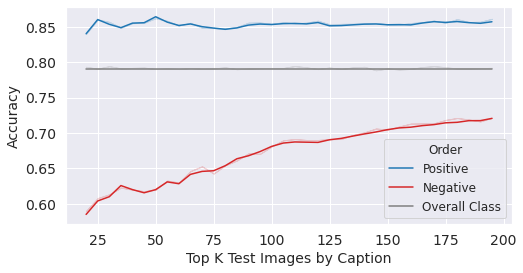

In [72]:
import src.clip_utils as clip_utils
cifar_label_list = np.array([CLASS_DICT['CIFAR'][u] for u in range(10)])

clip_analyzer = viz_utils.ClipAnalyzer(
    processor=processor, svm_model_name=svm_model_name, caption_set_name="CIFAR", class_names=cifar_label_list)

def get_cdf(arr, K_range=None):
    out = []
    if K_range is None:
        K_range = np.arange(10, len(arr), 10)
    for K in K_range:
        out.append(arr[:K].mean())
    out = np.array(out)
    return out, K_range

saved_caption_and_most_relevant_imgs = {}
all_dfs = []
for target_class in range(10):
    print(processor.metrics['cv_scores'][target_class])
    print("performing classify captions on svm")
    result = clip_analyzer.get_svm_style_top_K(target_class, 'all')
    print("--------")

    cdfs = {}
    class_mask = test_class==target_class
    masked_indices = np.arange(len(test_class))[class_mask]
    # K_range = np.arange(10, len(masked_indices), 10)
    K_range=np.arange(20, 200, 5)
    for caption_index in range(1):
        for direction in ['pos', 'neg']:
            caption_text = result[f'{direction}_captions'][caption_index]
            print(f"{direction}: {caption_text}")
            top_caption_latent = torch.tensor(result[f'{direction}_latents'][caption_index]).cuda()

            image_latents = clip_analyzer.clip_features['test'][class_mask].cuda()
            image_angles = clip_utils.order_descriptions_angle(mean_point=top_caption_latent.unsqueeze(0), query_points=image_latents)
            image_order = np.argsort(image_angles)[::-1]
            saved_caption_and_most_relevant_imgs[(target_class, caption_index, direction)] = (masked_indices[image_order], caption_text)
            dir_name = 'Positive' if direction == 'pos' else 'Negative' 
            cdfs[dir_name], _ = get_cdf(test_correct[masked_indices[image_order]], K_range)
            # uncomment this to display the images

        df = pd.DataFrame()
        df['Top K'] = K_range
        for d, v in cdfs.items():
            df[d] = v
        df['Overall Class'] = test_correct[masked_indices].mean()
        df = df.melt('Top K', var_name='Order', value_name='Accuracy')
        all_dfs.append(df)
    
combined_df = pd.concat(all_dfs).reset_index()
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.lineplot(data=combined_df, x='Top K', y='Accuracy', hue='Order', ax=ax, 
             hue_order=['Positive', 'Negative', 'Overall Class'], 
            palette=[BLUE, RED, GRAY], ci=False)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels)
ax.set_xlabel("Top K Test Images by Caption")
plt.show()
    

tensor(0.8023) tensor(0.8042)


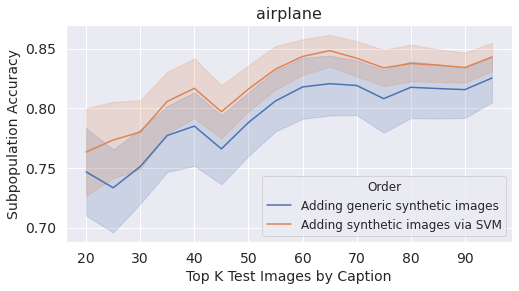

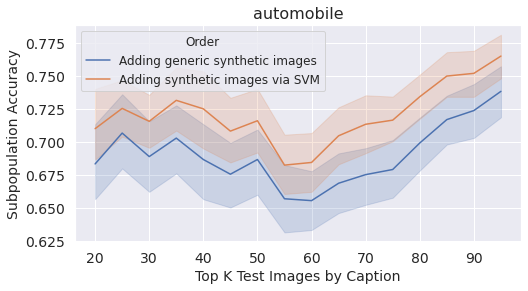

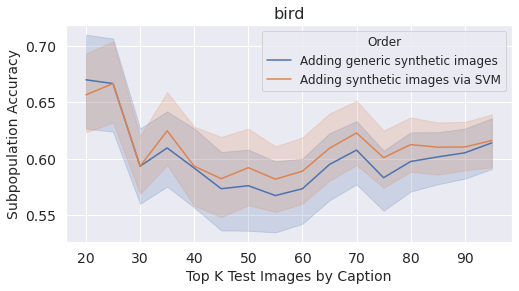

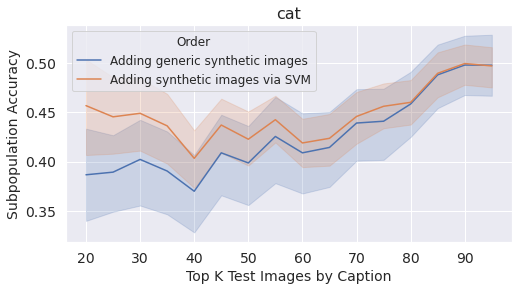

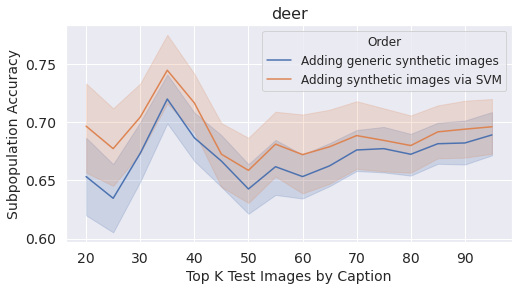

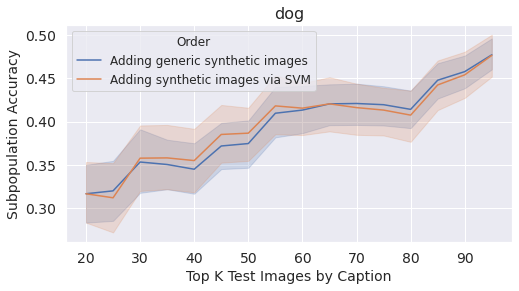

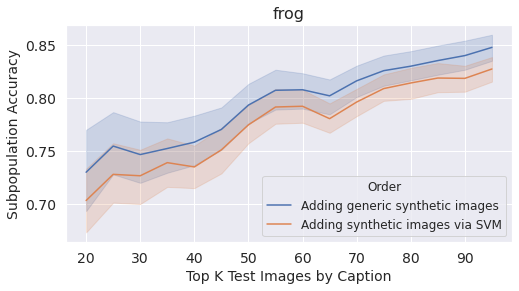

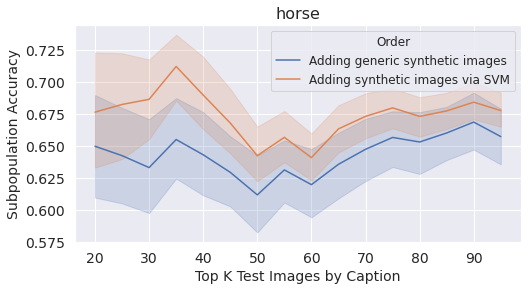

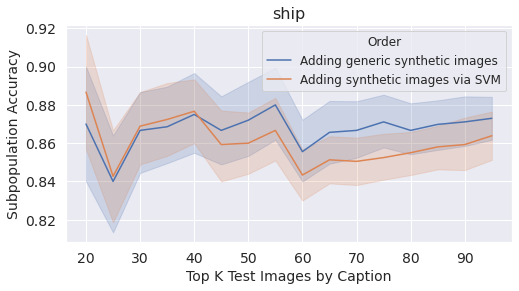

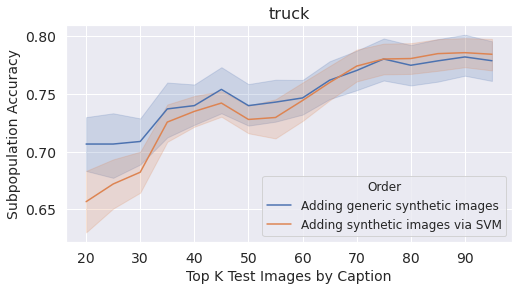

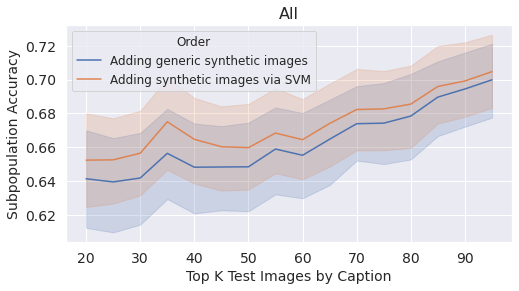

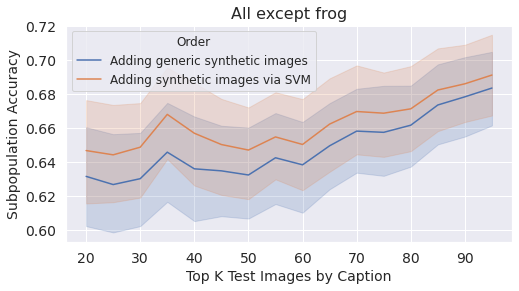

In [54]:
intensity = 0.1
load_corrects = {
    'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
    'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
#     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

}
trials = len(flip_interventions[0])
print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

K = 100



#         print(cifar_label_list[target_class], base_accs[target_class], orig_accs[target_class])
all_dfs = []
for v in range(trials):
    dfs = []
    for target_c in np.arange(num_classes):
        xaxis = np.arange(20, 100, 5)
        indices, caption = saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')]
        base, _ = get_cdf(load_corrects['base'][v][indices].float(), xaxis)
        flip, _ = get_cdf(load_corrects[('flip')][v][indices].float(), xaxis)

        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = base
        df['Adding synthetic images via SVM'] = flip

        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        df['Class'] = target_c
        dfs.append(df)
    combined_df = pd.concat(dfs).reset_index()
    combined_df = combined_df.groupby(['Top K', 'Order', 'Class']).mean().reset_index()[['Top K', 'Order', 'Subpopulation Accuracy', 'Class']]
    all_dfs.append(combined_df)
    
def plot_sub_df(sub_df, title):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.lineplot(data=sub_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    ax.set_title(title)
    plt.show()
    
df = pd.concat(all_dfs).reset_index()
for target_class in np.arange(num_classes):
    plot_sub_df(df[df['Class'] == target_class], cifar_label_list[target_class])
plot_sub_df(df, "All")
plot_sub_df(df[df['Class'] != 6], "All except frog")
    

tensor(0.8023) tensor(0.8042)
tensor(0.7954) tensor(0.8042)
tensor(0.8014) tensor(0.8042)


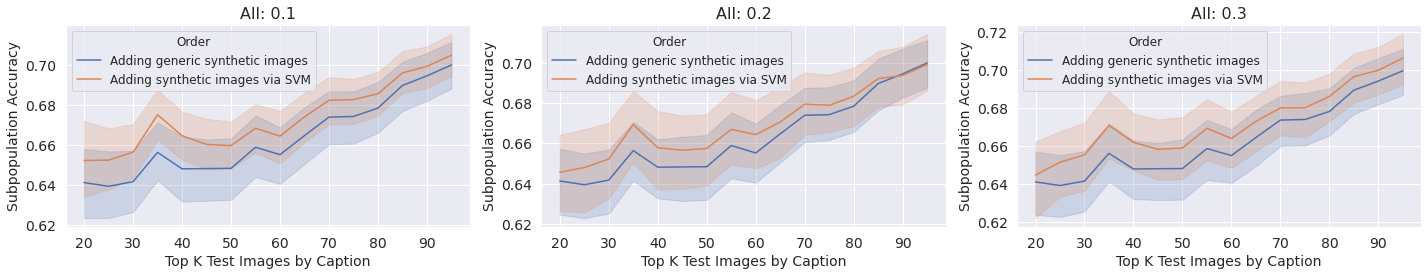

In [73]:
def get_dv_indices(target_c):
    mask = test_class == target_c
    inds = np.arange(len(big_clip_dv))[mask]
    return inds[np.argsort(big_clip_dv[mask])]

fig, ax_ = plt.subplots(1, 3, figsize=(20, 4))
cls = -1
if cls == -1:
    flip_interventions = torch.load("cifar10_sd_results.pt")
else:
    flip_interventions = torch.load(f"/mnt/cfs/home/saachij/src/failure-directions/failure_directions/cifar_sd_{cls}.pt")
for intensity_idx, intensity in enumerate([0.1, 0.2, 0.3]):
    ax = ax_[intensity_idx]
    load_corrects = {
        'flip': [(flip_interventions[intensity][u][0] == flip_interventions[intensity][u][1]) for u in range(len(flip_interventions[intensity]))],
        'base': [(flip_interventions[0][u][0] == flip_interventions[0][u][1]) for u in range(len(flip_interventions[0]))],
    #     'none': [(no_intervention[u][0] == no_intervention[u][1]) for u in range(5)],

    }
    trials = len(flip_interventions[0])
    print(torch.stack(load_corrects['flip']).float().mean(), torch.stack(load_corrects['base']).float().mean())

    K = 100


    all_dfs = []
    # valid_classes = np.arange(10)
    if cls == -1:
        valid_classes = np.arange(10)
    else:
        valid_classes = [cls]
    for v in range(trials):
        xaxis = np.arange(20, 100, 5)
        base, flip = [], []
        for K in xaxis:
#             minority_indices = np.concatenate([get_dv_indices(target_c)[:K] for target_c in valid_classes])
            minority_indices = np.concatenate([saved_caption_and_most_relevant_imgs[(target_c, 0, 'neg')][0][:K] for target_c in valid_classes])
            base.append(load_corrects['base'][v][minority_indices].float().mean().item())
            flip.append(load_corrects[('flip')][v][minority_indices].float().float().mean().item())
        df = pd.DataFrame()
        df['Top K'] = xaxis
        df['Adding generic synthetic images'] = base
        df['Adding synthetic images via SVM'] = flip
        df = df.melt('Top K', var_name='Order', value_name='Subpopulation Accuracy')
        all_dfs.append(df)


    all_df = pd.concat(all_dfs).reset_index()

    sns.lineplot(data=all_df, x='Top K', y='Subpopulation Accuracy', hue='Order', ax=ax)
    ax.set_xlabel("Top K Test Images by Caption")
    t = 'All' if cls == -1 else cifar_label_list[cls]  
    ax.set_title(f'{t}: {intensity}')
plt.tight_layout()
plt.show()


In [62]:
sub_df

,index,Top K,Order,Subpopulation Accuracy,Class
9,9,20,Adding generic synthetic images,0.700000,9
19,19,20,Adding synthetic images via SVM,0.750000,9
29,29,25,Adding generic synthetic images,0.720000,9
39,39,25,Adding synthetic images via SVM,0.760000,9
49,49,30,Adding generic synthetic images,0.733333,9
...,...,...,...,...,...
4759,279,85,Adding synthetic images via SVM,0.823529,9
4769,289,90,Adding generic synthetic images,0.833333,9
4779,299,90,Adding synthetic images via SVM,0.822222,9
4789,309,95,Adding generic synthetic images,0.831579,9


In [52]:
df

,index,Top K,Order,Subpopulation Accuracy,Class
0,0,20,Adding generic synthetic images,0.800000,0
1,1,20,Adding generic synthetic images,0.700000,1
2,2,20,Adding generic synthetic images,0.650000,2
3,3,20,Adding generic synthetic images,0.350000,3
4,4,20,Adding generic synthetic images,0.650000,4
...,...,...,...,...,...
4795,315,95,Adding synthetic images via SVM,0.589474,5
4796,316,95,Adding synthetic images via SVM,0.852632,6
4797,317,95,Adding synthetic images via SVM,0.694737,7
4798,318,95,Adding synthetic images via SVM,0.915789,8


In [65]:
clip_analyzer.captions['reference']

['a photo of a airplane',
 'a photo of a automobile',
 'a photo of a bird',
 'a photo of a cat',
 'a photo of a deer',
 'a photo of a dog',
 'a photo of a frog',
 'a photo of a horse',
 'a photo of a ship',
 'a photo of a truck']

In [13]:
out = torch.load("synth_model_results.pt")

In [14]:
no_intervention = out['no_intervention']
flip_interventions = out['flip_intervention']
base_intervention = out['base_intervention']

In [81]:
no_intervention

[(tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.9736, 0.9980, 0.9996,  ..., 0.9998, 0.9998, 0.9724])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8502, 0.9268, 0.9994,  ..., 0.9996, 0.9960, 0.9489])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.7708, 0.9999, 1.0000,  ..., 0.9988, 0.9972, 0.9987])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.6072, 0.9871, 0.9984,  ..., 0.9992, 0.9999, 0.9983])),
 (tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([3, 8, 8,  ..., 5, 1, 7]),
  tensor([0.8949, 0.9939, 0.9277,  ..., 0.9601, 0.8612, 0.9952]))]

In [ ]:
out = np.load("/mnt/nfs/projects/data-transfer/mturk_target_groupings/infl_values.npy")

In [ ]:
imagenet_label_list = np.array([CLASS_DICT['ImageNet'][u].split(',')[0] for u in range(1000)])